In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from pyFTS.benchmarks import Measures
from pyFTS.benchmarks import Measures
from pyFTS.common import Util
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import math
import statistics

import sys
sys.path.append("/home/hugo/projetos-doutorado/mimo_emb_fts/src/")

from embfts.util.DataSetUtil import DataSetUtil
from embfts.util.StatisticsUtil import StatisticsUtil

In [76]:
data_set_util = DataSetUtil()
statistics_util = StatisticsUtil()

In [77]:
df = pd.read_csv('/home/hugo/projetos-doutorado/mimo_emb_fts/data/energydata_complete.csv', sep=',')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data = data_set_util.clean_dataset(data)
#data = data_set_util.series_to_supervised_mimo(data, 1, 1)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [51]:
def tv_ar1(dados, beta):
  n = len(dados)
  alfas = np.ones(n+1)
  alfa = 1.
  ret = np.zeros(n)
  ret[0] = dados[0]
  for i in range(2, n):
    ret[i] = dados[i-1] * alfa
    alfas[i] = dados[i-1]/dados[i-2] if dados[i-2] > 0 else 0 
    alfa = beta * alfas[i] + (1 - beta) * alfa
  
  return ret[2:]

In [52]:
forecast = tv_ar1(data.values[:,2], 1)

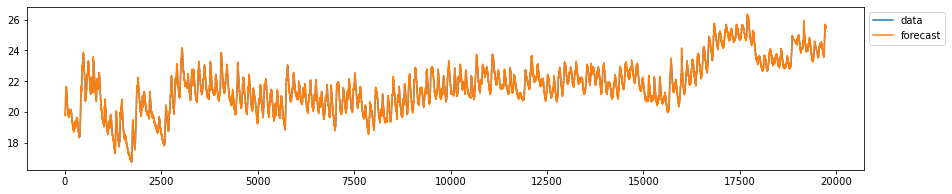

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(data.values[:,2], label='data')
ax.plot(forecast, label='forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [54]:
def tv_arma11(dados, gamma, delta):

  previsoes_ar = tv_ar1(dados, gamma)

  residuos_ar = dados[2:] - previsoes_ar

  previsoes_ma = tv_ar1(residuos_ar, delta)

  return previsoes_ar[2:] + previsoes_ma

In [61]:
forecast1 = tv_arma11(data.values[:,2],0.5, 0.1)

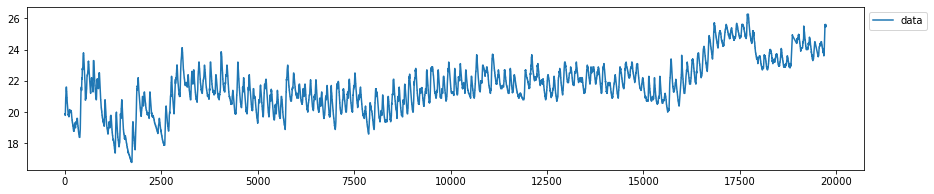

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(data.values[:,2], label='data')
#ax.plot(forecast1, label='forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [57]:
def kalman_predicao(a, V, F, G, tau):
  a_t = F @ a
  V_t = F @ V @ F.T + (tau * G @ G.T)

  return a_t, V_t

def kalman_filtragem(a, V, y, H, sigma):
  p = len(a)
  K =  V @ H.T * (H @ V @ H.T + sigma)**-1
  res_y = y - (H @ a)
  a_t = a + K * res_y
  V_t = (np.eye(p) - K @ H) @ V

  return a_t, V_t

def suavizacao(a, a_t, V, V_t, alpha ):
  a_f = alpha * a + (1 - alpha) * a_t
  V_f = alpha * V + (1 - alpha) * V_t
  return a_f, V_f

def tv_ar_kalman(dados, p, alfa=.9):
  n = len(dados)
  
  ## INICIALIZAÇÃO

  # Vetor de Estado / Coeficientes
  a = np.random.rand(p)
  a_t = a

  # Matrizes de Covariância
  V = np.eye(p)
  V_t = V
  F = np.eye(p)
  G = np.eye(p)

  # Resíduos e Variâncias
  res_y = np.ones(n) 
  sigma = 1.
  res_a = np.ones(n) 
  tau = 1.


  ret = np.zeros(n)
  ret[:p] = dados[:p]
  H = dados[0:p] 
  
  for i in range(p, n):

    # PREDIÇÃO DE ŷ(t+1)

    H_t = H
    H = dados[i-p:i]  # Vetor de defasagens / lags
    y = a @ H
    ret[i] = y

    #ATUALIZAÇÃO DOS COEFICIENTES USANDO O FILTRO DE KALMAN

    a_t = a
    V_t = V
    a, V = kalman_predicao(a_t, V_t, F, G, tau)
    a, V = kalman_filtragem(a, V, dados[i-1], H_t, sigma)
    a, V = suavizacao(a, a_t, V, V_t, alfa)
    
    # Resíduos de Y
    res_y[i] = dados[i] - y
    sigma = np.std(res_y)

    #Resíduos de a
    res_a[i] = np.mean(a_t - a)
    tau = np.std(res_a)

  return ret[p:]


In [58]:
n = len(data)
p = 2
q = 0

In [59]:
forecast2 = tv_ar_kalman(data.values[:,0],p, .9)

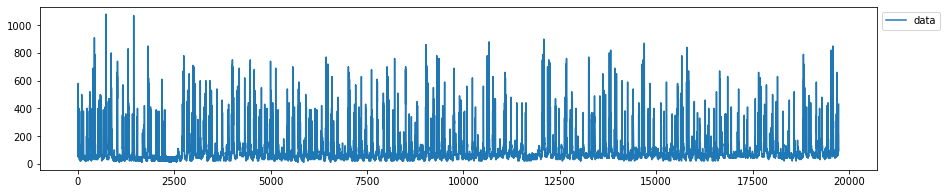

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(data.values[:,0], label='data')
#ax.plot(forecast2, label='forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [78]:

# VARMA example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
# data = list()
# for i in range(100):
#     v1 = random()
#     v2 = v1 + random()
#     row = [v1, v2]
#     data.append(row)
# # fit model
model = VARMAX(data, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast()
print(yhat)

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


KeyboardInterrupt: 

In [ ]:
len(data)